#### Задание 
Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов)

In [1]:
import pandas as pd
from string import punctuation
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import re
import html
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking
from keras.objectives import categorical_crossentropy

Using TensorFlow backend.


In [3]:
np.random.seed(42)

In [4]:
stopwords=set(stopwords.words('russian'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

#### Подготовка датасета

In [5]:
data = pd.read_excel("отзывы за лето.xls")
data.head(20)

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
5,5,Всё удобно норм 👍👍👍,2017-08-14
6,5,Очень удобное приложение.,2017-08-14
7,5,Все устраивает,2017-08-14
8,5,У меня работает все четко. В отличии от банком...,2017-08-14
9,5,Очень все хорошо👍,2017-08-14


In [6]:
emoticon_dict = {
":)": "веселый",
":‑)": "веселый",
":-]": "веселый",
":-3": "веселый",
":->": "веселый",
"8-)": "веселый",
":-}": "веселый",
":o)": "веселый",
":c)": "веселый",
":^)": "веселый",
"=]": "веселый",
"=)": "веселый",
"<3": "веселый",
":-(": "грустный",
":(": "грустный",
":c": "грустный",
":<": "грустный",
":[": "грустный",
">:[": "грустный",
":{": "грустный",
">:(": "грустный",
":-c": "грустный",
":-< ": "грустный",
":-[": "грустный",
":-||": "грустный"
}

In [7]:
def  replace_words_in_dictonary(text, dictionary_words):     
    return ' '.join(dictionary_words.get(word, word) for word in text.split())

### Заменим эмотиконы (пример: ":)" = "happy") на пробелы, используя emoticon_dict. 
### Для этого воспользуемся функцией, используемой в предыдущем пункте.
def replace_emoticon(text):
    global emoticon_dict
    return replace_words_in_dictonary(str(text), emoticon_dict)

def replace_special_symbol(text):
    return  html.unescape(text)

def preprocess_text(text):
    global stopwords, exclude, morpher
    
    text = str(text)
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = replace_emoticon(text)
    text = replace_special_symbol(text)
    text = "".join(c for c in text if c not in exclude)
    text = re.sub(r'[^\w\s]',' ', text)
    text = re.sub(r'[0-9]+', ' ', text)
    text = re.sub('\n', ' ', text)
    text = [morpher.parse(word)[0].normal_form for word in text.split() if word not in stopwords]
    text = " ".join(text)
    text = re.sub("не\s", "не", text)
    return text

In [8]:
data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3] #удаляем строки
data['target'] = (data['Rating'] > 3).astype(int)
data.head(20)

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной приложениеиз минус хотеть слиш...,1
2,5,Отлично все,2017-08-14,отлично,1
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать зависать работа антивирус далёкий никуда...,1
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать быстро,1
5,5,Всё удобно норм 👍👍👍,2017-08-14,весь удобно норма,1
6,5,Очень удобное приложение.,2017-08-14,очень удобный приложение,1
7,5,Все устраивает,2017-08-14,устраивать,1
8,5,У меня работает все четко. В отличии от банком...,2017-08-14,работать чётко отличие банкомат который вечно ...,1
9,5,Очень все хорошо👍,2017-08-14,очень,1


In [9]:
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=42, stratify=data['target'])
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5,
                                                    random_state=42, stratify=y_val)

In [10]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ') 
tokenizer.fit_on_texts(X_train)  

max_words = len(tokenizer.index_word) + 1
max_len  = max([len(i.split()) for i in X_train])

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,  maxlen=max_len)
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,  maxlen=max_len)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test,  maxlen=max_len)

#### Структура сети

In [11]:
history = {}

# Training
epochs = 20 
batch_size = 512

In [12]:
def get_model(name='baseline', metric='accuracy'):
    global max_len, max_words
    model = Sequential(name=name)
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    if name == 'RNN':
        model.add(Masking(mask_value=0.0))
        model.add(SimpleRNN(16, return_sequences=True, recurrent_dropout=0.2, dropout=0.4))
        model.add(SimpleRNN(16, return_sequences=True, recurrent_dropout=0.2, dropout=0.4))
        model.add(SimpleRNN(16, return_sequences=False, recurrent_dropout=0.2, dropout=0.4))
    elif name=='GRU':
        model.add(Masking(mask_value=0.0))
        model.add(GRU(16, return_sequences=True, recurrent_dropout=0.2, dropout=0.4))
        model.add(GRU(16, return_sequences=True, recurrent_dropout=0.2, dropout=0.4))
        model.add(GRU(16, return_sequences=False, recurrent_dropout=0.2, dropout=0.4))
    elif name=='LSTM':
        model.add(Masking(mask_value=0.0))
        model.add(LSTM(16, return_sequences=True, recurrent_dropout=0.2, dropout=0.4))
        model.add(LSTM(16, return_sequences=True, recurrent_dropout=0.2, dropout=0.4))
        model.add(LSTM(16, return_sequences=False, recurrent_dropout=0.2, dropout=0.4))
    else:
        model.add(Conv1D(32, 3))
        model.add(Activation("relu"))
        model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[metric])
    return model

#### Обучение

In [13]:
type_models = ['baseline', 'RNN', 'GRU', 'LSTM']

In [15]:
for type_model in type_models:
    print(f'{type_model}:')
    metric = keras.metrics.AUC()
    metric.name='auc'
    model = get_model(type_model, metric)

    history[type_model] = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_val, y_val))

    score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    model.summary()
    print(f'Score {type_model}: Test loss:{score[0]}, Test AUC:{score[1]}')
    del model

baseline:
Train on 15798 samples, validate on 1975 samples
Epoch 1/20
15798/15798 [==============================] - 5s 343us/step - loss: 0.5036 - auc: 0.5277 - val_loss: 0.4003 - val_auc: 0.9058
Epoch 2/20
15798/15798 [==============================] - 5s 294us/step - loss: 0.3278 - auc: 0.8650 - val_loss: 0.2477 - val_auc: 0.9373
Epoch 3/20
15798/15798 [==============================] - 5s 294us/step - loss: 0.1805 - auc: 0.9629 - val_loss: 0.2125 - val_auc: 0.9443
Epoch 4/20
15798/15798 [==============================] - 5s 285us/step - loss: 0.1357 - auc: 0.9770 - val_loss: 0.2062 - val_auc: 0.9478
Epoch 5/20
15798/15798 [==============================] - 5s 285us/step - loss: 0.1082 - auc: 0.9847 - val_loss: 0.2174 - val_auc: 0.9443
Epoch 6/20
15798/15798 [==============================] - 5s 287us/step - loss: 0.0871 - auc: 0.9891 - val_loss: 0.2303 - val_auc: 0.9410
Epoch 7/20
15798/15798 [==============================] - 5s 323us/step - loss: 0.0704 - auc: 0.9923 - val_loss: 

Train on 15798 samples, validate on 1975 samples
Epoch 1/20
15798/15798 [==============================] - 45s 3ms/step - loss: 357.2344 - auc: 0.6158 - val_loss: 0.5868 - val_auc: 0.8922
Epoch 2/20
15798/15798 [==============================] - 43s 3ms/step - loss: 37.5774 - auc: 0.7374 - val_loss: 0.4966 - val_auc: 0.9141
Epoch 3/20
15798/15798 [==============================] - 49s 3ms/step - loss: 158.0173 - auc: 0.7998 - val_loss: 0.4523 - val_auc: 0.9161
Epoch 4/20
15798/15798 [==============================] - 46s 3ms/step - loss: 0.4013 - auc: 0.8421 - val_loss: 0.3989 - val_auc: 0.9173
Epoch 5/20
15798/15798 [==============================] - 38s 2ms/step - loss: 0.3521 - auc: 0.8717 - val_loss: 0.3558 - val_auc: 0.9206
Epoch 6/20
15798/15798 [==============================] - 35s 2ms/step - loss: 0.3909 - auc: 0.8933 - val_loss: 0.3234 - val_auc: 0.9214
Epoch 7/20
15798/15798 [==============================] - 35s 2ms/step - loss: 0.2872 - auc: 0.9066 - val_loss: 0.2990 - val

#### Подготовка эмбеддинга

In [16]:
def plot_history(history):
    fig = plt.figure()
    fig.set_size_inches(15, 15)

    ax_1 = fig.add_subplot(2, 2, 1)
    ax_2 = fig.add_subplot(2, 2, 2)
    ax_3 = fig.add_subplot(2, 2, 3)
    ax_4 = fig.add_subplot(2, 2, 4)


    for key in history.keys():
        ax_1.plot(history[key].history['auc'], label=key)
        ax_2.plot(history[key].history['val_auc'], label=key)
        ax_3.plot(history[key].history['loss'], label=key)
        ax_4.plot(history[key].history['val_loss'], label=key)

    ax_1.set(title = 'Model AUC on train data', label='AUC', xlabel='Epoch')
    ax_1.legend(loc='lower right')
    ax_2.set(title = 'Model AUC on valid data', label='AUC', xlabel='Epoch')
    ax_2.legend(loc='lower right')
    ax_3.set(title = 'Model loss on train data', label='loss', xlabel='Epoch')
    ax_3.legend(loc='upper right')
    ax_4.set(title = 'Model loss on valid data', label='loss', xlabel='Epoch')
    ax_4.legend(loc='upper right')

    plt.show()

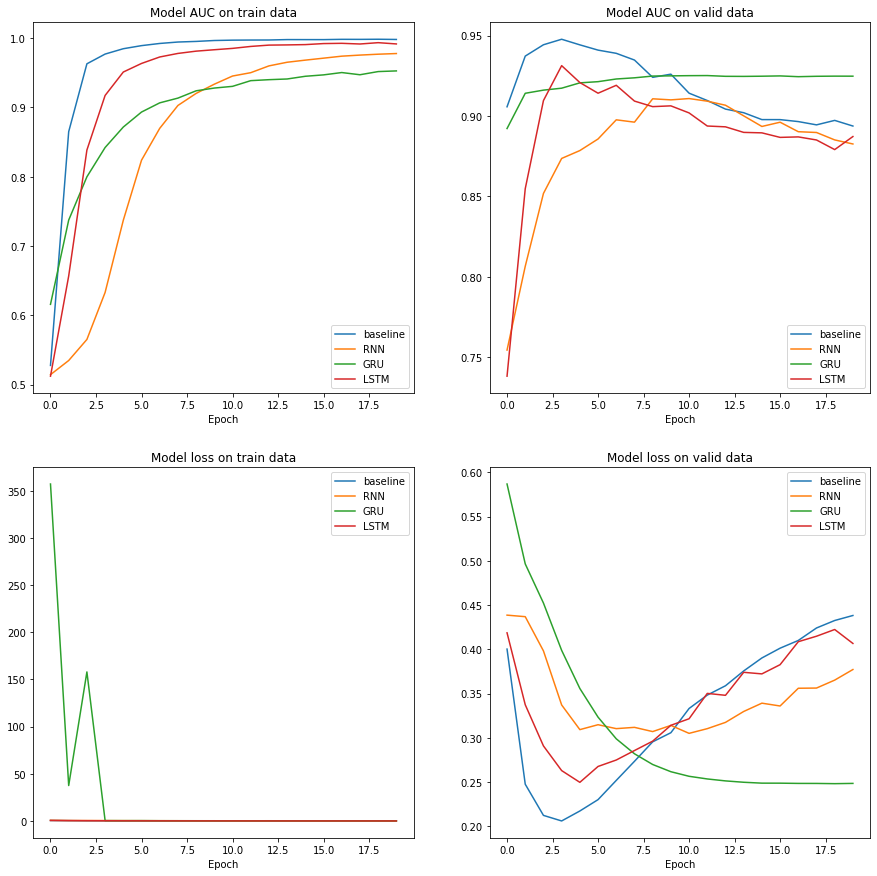

In [17]:
plot_history(history)

#### Вывод.  
Для наглядности обученик проводилось на 20 эпохах, что приводило к переобучению большинства моделей. Набор обучаемых параметров у всех сетей примерно одинаков.    
 - Для конкретной задачи использование рекурентного слоя или слоев различной модификации не дало значительного прироста метрики.  
 - Несколько слоев GRU хорошо борются с переобучением, но требуют значительного времени и эпох на обучение.  
 - Каскад LSTM позволяет показать схожие результаты с базовой сверточной нейросетью, но быстро переобучется.  
 - Худшие результаты показывает сеть из простых рекурентых слоев.  